In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 219 (delta 123), reused 168 (delta 85), pack-reused 0
Receiving objects: 100% (219/219), 2.68 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from layers import InputToCx, CxMO, FreeSpacePropagation, CxD2NNIntensity, D2NNMNISTDetector, ImageResize, D2NNMNISTFilter
import os
import glob

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [4]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [2]:
path = 'trained_model/20220319_1'
model = tf.keras.models.load_model(path)
model.summary()

2022-03-22 12:43:14.869199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-22 12:43:14.869536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resize_1 (ImageResize  (None, 100, 100)         0         
 )                                                               
                                                                 
 input_to_cx_1 (InputToCx)   (None, 2, 4, 100, 100)    0         
                                                                 
 cx_mo_1 (CxMO)              (None, 2, 4, 100, 100)    10000     
                                                                 
 free_space_propagation (Fre  (None, 2, 4, 100, 100)   0         
 eSpacePropagation)                                              
                                                                 
 cx_mo_2 (CxMO)              (N

## 正解率

2022-03-22 11:07:28.158293: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 11:07:28.233963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 80/313 [======>.......................] - ETA: 1:22 - loss: 1.6976 - accuracy: 0.4633

KeyboardInterrupt: 

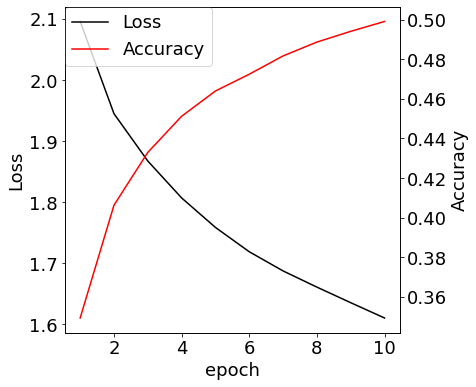

In [5]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

model.evaluate(x_test, y_test)

## 位相変調層

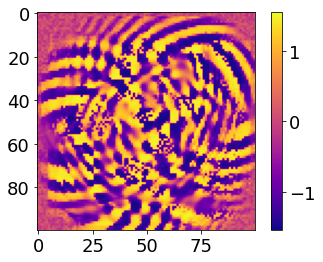

In [17]:
plt.imshow(90 * np.pi / 180* tf.tanh(model.layers[3].get_weights()[0]), cmap='plasma')
plt.colorbar()

## 出力プロット

2022-03-21 15:49:04.987633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 15:49:05.287320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


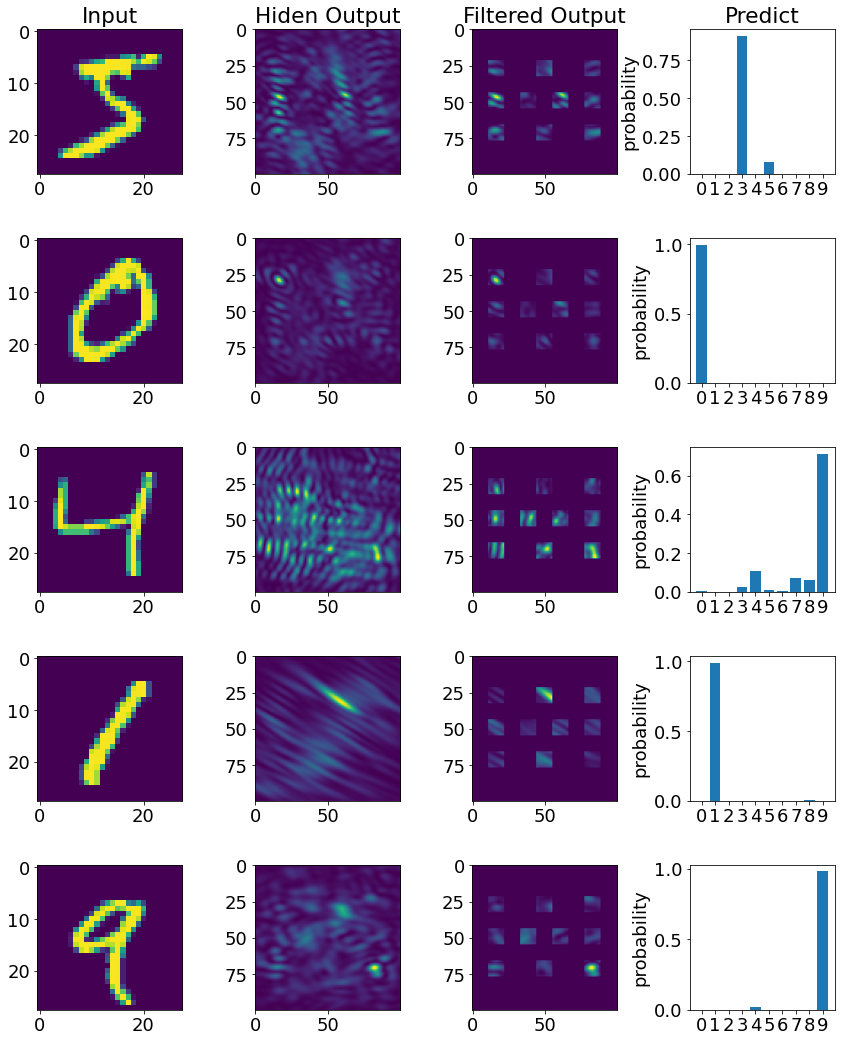

In [18]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num + 0, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('probability')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
    if i == 0:
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Hiden Output")
        axes[i, 2].set_title("Filtered Output")
        axes[i, 3].set_title("Predict")
        
fig.tight_layout()

## 2値化して出力プロット

2022-03-22 12:43:40.973386: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 12:43:41.037805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 12:43:41.733488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 12:43:42.439884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


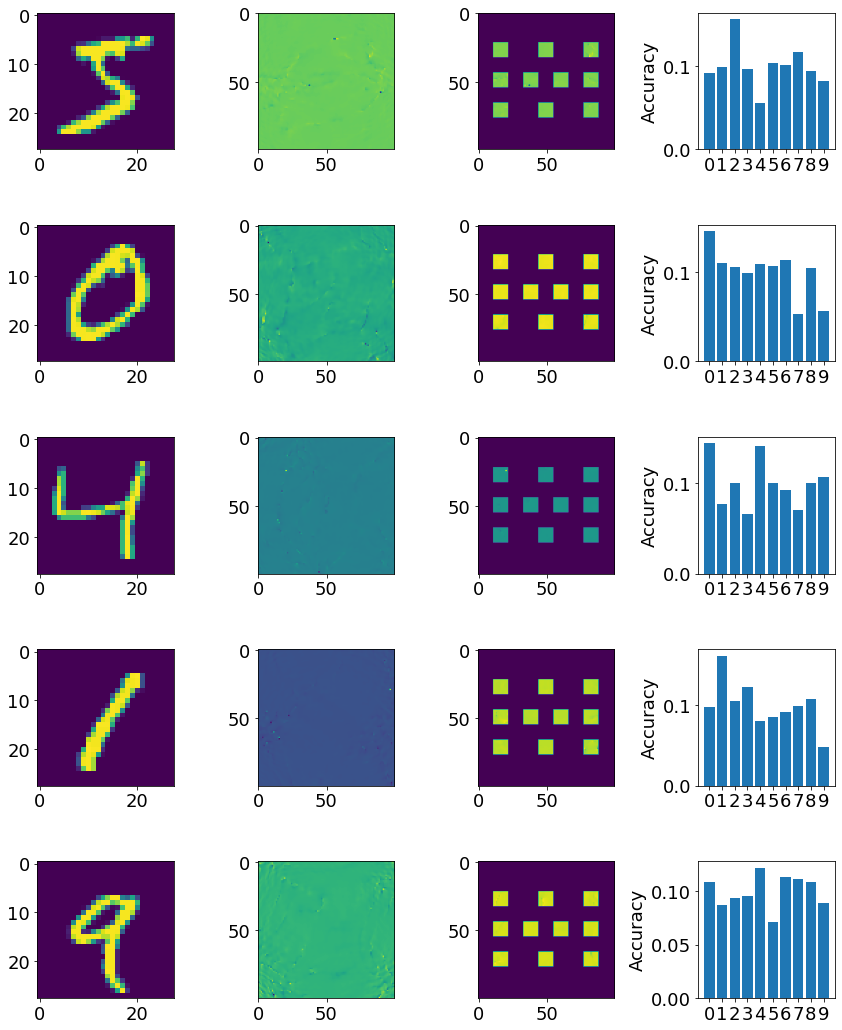

In [5]:
mo_layer_index = [3, 5]
limit_value = 2.1 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None

layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 15))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

In [7]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 111s 355ms/step - loss: 2.1712 - accuracy: 0.4658


[2.171151876449585, 0.465800017118454]

## 位相変調量

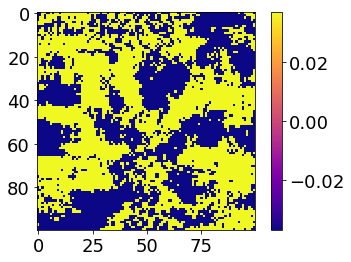

In [16]:
bi_phase = model.layers[5].get_weights()[0]
plt.imshow(bi_phase, cmap='plasma', interpolation='none')
plt.colorbar()
bi_phase = np.where(bi_phase >= 0, 1, -1)
np.savetxt('data/phase/20220319-1/layer2.csv', bi_phase, fmt='%d', delimiter=',')

## 学習過程の正解率比較

Text(0.5, 0, 'epoch')

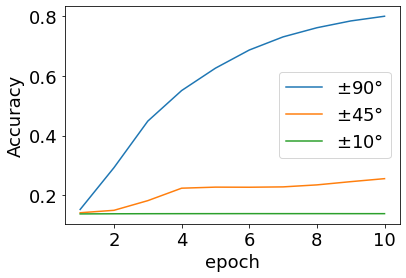

In [17]:
path = 'trained_model'
files = glob.glob(path + '/20220317*/history.csv')
labels = [r'$\pm 90\degree$', r'$\pm 45 \degree$', r'$\pm 10 \degree$']
for i, file in enumerate(files):
    history = pd.read_csv(file)
    plt.plot(range(1, history.index.stop + 1), history['accuracy'], label=labels[i])

plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epoch")

## 3値化

In [ ]:
mo_layer_index = [3]
sep = 90 * np.pi / 180
limit_value = 90 * np.pi / 180
for idx in mo_layer_index:
    phi = model.layers[idx].get_weights()
    phi_lim = tf.tanh(phi)
    phi_bi = tf.where(phi_lim >= 0, limit_value, -limit_value)
    model.layers[idx].set_weights(phi_bi)
    model.layers[idx].limitation=None